In [1]:
import sys

sys.path.insert(0, "..")

In [2]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import plot

import matplotlib.pyplot as plt
import textwrap

from tests.raster_processing.clip_test import raster_path as SMALL_RASTER_PATH
from eis_toolkit.training_data_tools.points_to_raster import points_to_raster
from eis_toolkit.training_data_tools.random_sampling import generate_negatives

PATH_LABELS_GPKG = "../tests/data/remote/interpolating/interpolation_test_data_small.gpkg"
RASTER_PATH = "../tests/data/remote/small_raster.tif"

# Creating data points

In [3]:
gdf = gpd.read_file(PATH_LABELS_GPKG)
print(gdf)

      id  value                        geometry
0    1.0   10.0  POINT (384758.306 6671365.922)
1    2.0   20.0  POINT (384769.919 6671362.194)
2    3.0   30.0  POINT (384769.059 6671350.580)
3    4.0   40.0  POINT (384777.519 6671344.128)
4    5.0   35.0  POINT (384761.030 6671342.264)
5    6.0   25.0  POINT (384758.306 6671355.025)
6    7.0   50.0  POINT (384783.397 6671365.205)
7    8.0  100.0  POINT (384795.584 6671358.179)
8    9.0  120.0  POINT (384795.728 6671344.988)
9   11.0   79.0  POINT (384786.408 6671335.955)
10  12.0   60.0  POINT (384780.243 6671327.783)
11  13.0   50.0  POINT (384771.497 6671320.040)
12   NaN   40.0  POINT (384791.797 6671314.259)
13   NaN   30.0  POINT (384799.487 6671303.044)
14   NaN   20.0  POINT (384808.459 6671290.707)
15   NaN   30.0  POINT (384787.791 6671295.033)
16   NaN   30.0  POINT (384815.509 6671310.254)
17   NaN   20.0  POINT (384826.244 6671297.436)
18   NaN   15.0  POINT (384825.763 6671287.503)
19   NaN   10.0  POINT (384815.349 66712

# Creating binary raster from template raster

In [4]:
def plot_binary_raster_from_template_raster(template_raster_path):

    attribute = 'value'
    radius = 3
    
    with rasterio.open(template_raster_path) as temp_raster:
        
        outarray,outmeta = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            nodata_value=-999)
        
        outarray2,outmeta2 = points_to_raster(positives=gdf,
                                            attribute=attribute,
                                            template_raster=temp_raster,
                                            nodata_value=-999)
        
        outarray3,outmeta3 = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            radius=radius,
                                            nodata_value=-999)
        
        outarray4,outmeta4 = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            attribute=attribute,
                                            radius=radius,
                                            nodata_value=-999)
        
        outarray5,outmeta5 = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            attribute=attribute,
                                            radius=radius,
                                            nodata_value=-999,
                                            buffer='avg')
        
        outarray6,outmeta6 = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            attribute=attribute,
                                            radius=radius,
                                            nodata_value=-999,
                                            buffer='min')
        
        outarray7,outmeta7 = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            attribute=attribute,
                                            radius=radius,
                                            nodata_value=-999,
                                            buffer='max')

        extent = [temp_raster.bounds.left, temp_raster.bounds.right,
                  temp_raster.bounds.bottom, temp_raster.bounds.top]

        fig,axes = plt.subplots(3,3,figsize=(20,15))
        norm = plt.Normalize(vmax=np.nanmax(outarray), vmin=np.nanmin(outarray))
        norm2 = plt.Normalize(vmax=np.nanmax(outarray2), vmin=np.nanmin(outarray2))

        plot.show(temp_raster, ax=axes[0][0])
        axes[0][0].set_title('Template Raster with positives.', fontsize=15)
        points = gdf.cx[
                temp_raster.bounds.left : temp_raster.bounds.right,  # noqa: E203
                temp_raster.bounds.bottom : temp_raster.bounds.top,  # noqa: E203
            ]
        points.plot(ax=axes[0][0], facecolor='w', edgecolor='w')

        im1 = axes[0][1].imshow(outarray, cmap='gray', norm=norm, extent=extent)
        axes[0][1].set_title(textwrap.fill('True positives converted to raster.', width=30), fontsize=15)
        fig.colorbar(im1, ax=axes[0][1], orientation='vertical')

        im2 = axes[0][2].imshow(outarray2, cmap='gray', norm=norm2, extent=extent)
        axes[0][2].set_title(textwrap.fill('True positives converted to raster with attribute.', width=30), fontsize=15)
        fig.colorbar(im2, ax=axes[0][2], orientation='vertical')

        im3 = axes[1][0].imshow(outarray3, cmap='gray', norm=norm, extent=extent)
        axes[1][0].set_title(textwrap.fill('True positives converted to raster with radius.', width=30), fontsize=15)
        fig.colorbar(im3, ax=axes[1][0], orientation='vertical')

        im4 = axes[1][1].imshow(outarray4, cmap='gray', norm=norm2, extent=extent)
        axes[1][1].set_title(textwrap.fill('True positives converted to raster with attribute and radius.', width=30), fontsize=15)
        fig.colorbar(im4, ax=axes[1][1], orientation='vertical')

        im5 = axes[1][2].imshow(outarray5, cmap='gray', norm=norm2, extent=extent)
        axes[1][2].set_title(textwrap.fill('True positives converted to raster with attribute and radius and averaging buffer.', width=30), fontsize=15)
        fig.colorbar(im5, ax=axes[1][2], orientation='vertical')
        
        im6 = axes[2][0].imshow(outarray6, cmap='gray', norm=norm2, extent=extent)
        axes[2][0].set_title(textwrap.fill('True positives converted to raster with attribute and radius and min buffer.', width=30), fontsize=15)
        fig.colorbar(im6, ax=axes[2][0], orientation='vertical')

        im7 = axes[2][1].imshow(outarray7, cmap='gray', norm=norm2, extent=extent)
        axes[2][1].set_title(textwrap.fill('True positives converted to raster with attribute and radius and max buffer.', width=30), fontsize=15)
        fig.colorbar(im7, ax=axes[2][1], orientation='vertical')

        axes[2][2].axis('off')

        plt.tight_layout()
        plt.show()

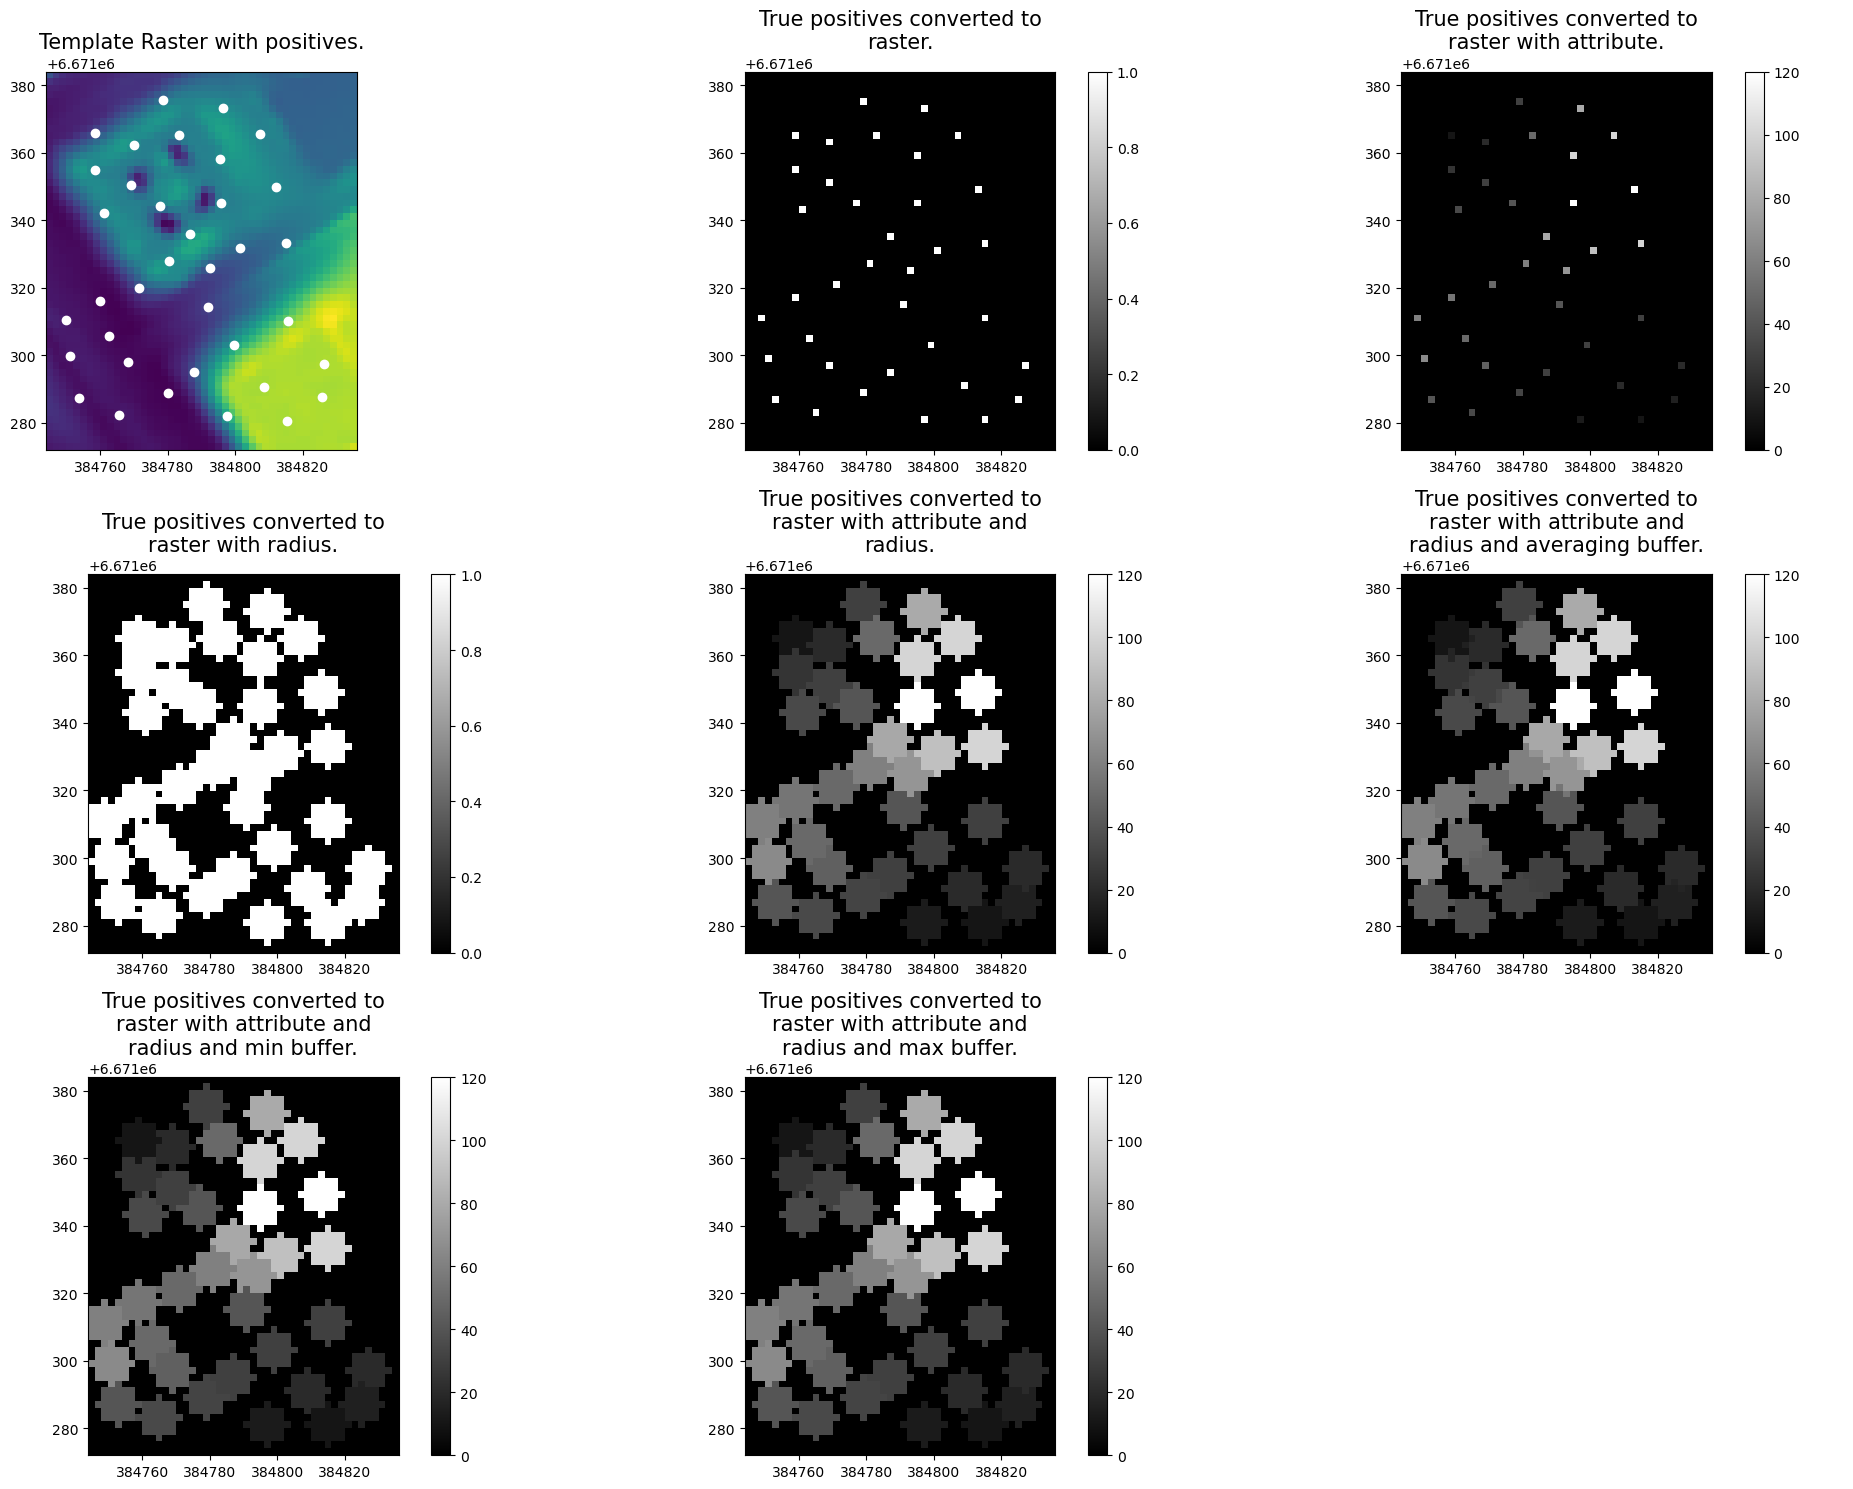

In [5]:
plot_binary_raster_from_template_raster(SMALL_RASTER_PATH)

In [6]:
def plot_samples(template_raster_path):

    attribute = 'value'
    radius = 3
    
    with rasterio.open(template_raster_path) as temp_raster:
        
        outarray,outmeta = points_to_raster(positives=gdf,
                                            template_raster=temp_raster,
                                            nodata_value=-999)
        
        sampled_negatives, outarray2, _ = generate_negatives(raster_array=outarray,
                                                 raster_meta=outmeta,
                                                 sample_number=10,
                                                 random_seed=30)
        
        extent = [temp_raster.bounds.left, temp_raster.bounds.right,
                  temp_raster.bounds.bottom, temp_raster.bounds.top]

        fig,axes = plt.subplots(2,2,figsize=(20,15))
        norm = plt.Normalize(vmax=np.nanmax(outarray), vmin=np.nanmin(outarray))
        norm2 = plt.Normalize(vmax=np.nanmax(outarray2), vmin=np.nanmin(outarray2))

        plot.show(temp_raster, ax=axes[0][0])
        axes[0][0].set_title('Template Raster with positives', fontsize=15)
        points = gdf.cx[
                temp_raster.bounds.left : temp_raster.bounds.right,  
                temp_raster.bounds.bottom : temp_raster.bounds.top,  
            ]
        points.plot(ax=axes[0][0], facecolor='w', edgecolor='w')

        im1 = axes[0][1].imshow(outarray, cmap='gray', norm=norm, extent=extent)
        axes[0][1].set_title(textwrap.fill('True positives converted to raster.', width=30), fontsize=15)
        fig.colorbar(im1, ax=axes[0][1], orientation='vertical')

        plot.show(temp_raster, ax=axes[1][0])
        axes[1][0].set_title('Template Raster with positives and random negatives', fontsize=15)
        sampled_negatives.plot(ax=axes[1][0], facecolor='r', edgecolor='r')
        points.plot(ax=axes[1][0], facecolor='w', edgecolor='w')

        im1 = axes[1][1].imshow(outarray2, cmap='gray', norm=norm2, extent=extent)
        axes[1][1].set_title(textwrap.fill('True positives and sampled negatives converted to raster.', width=30), fontsize=15)
        fig.colorbar(im1, ax=axes[1][1], orientation='vertical')

        plt.tight_layout()
        plt.show()

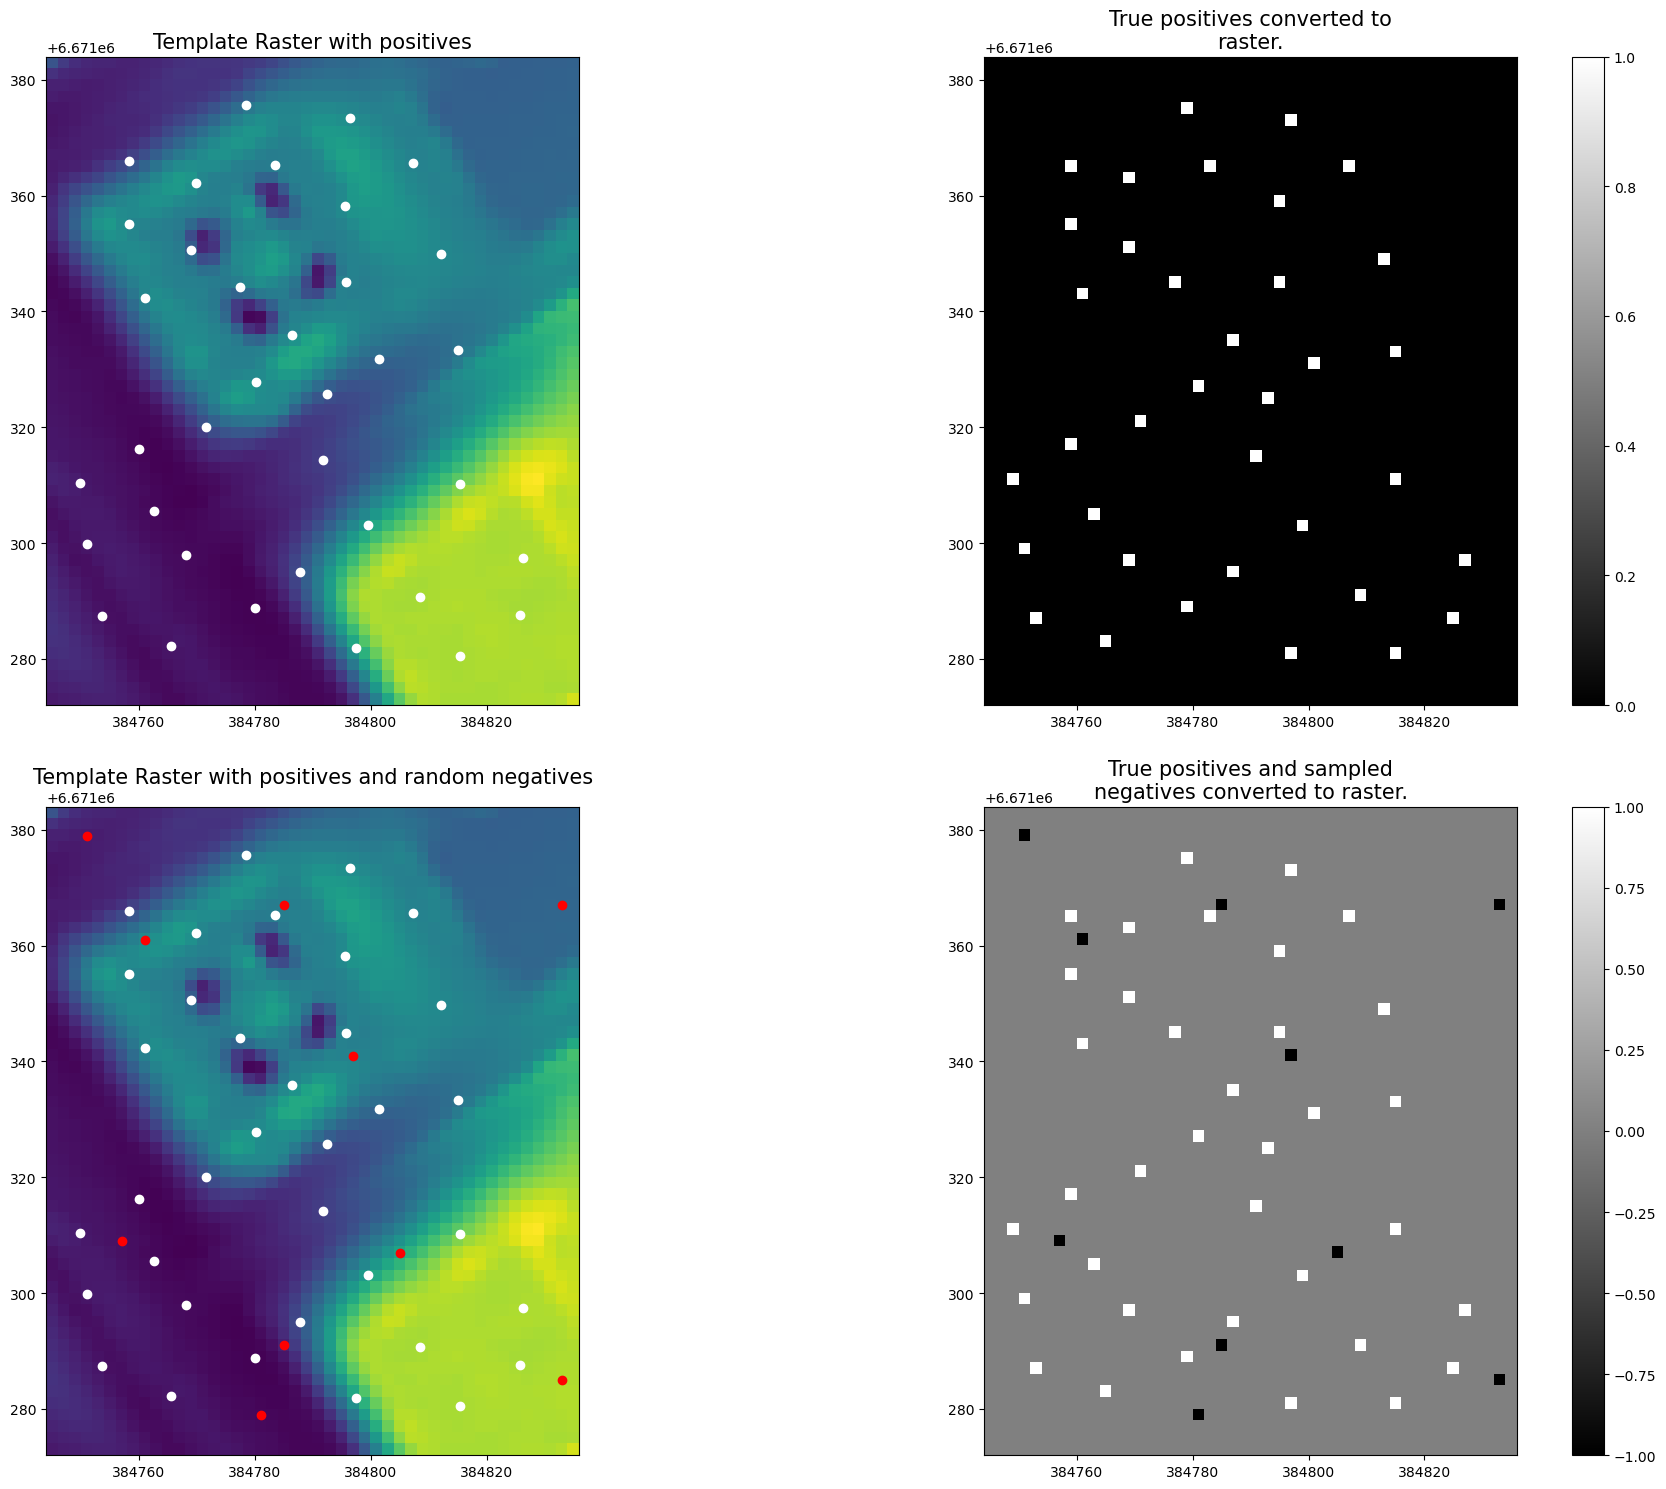

In [7]:
plot_samples(SMALL_RASTER_PATH)